# Exercise 4 Question 8

In [1]:
import tensorflow as tf
import numpy as np
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
tfd = tf.contrib.distributions

%matplotlib notebook 

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

## Encoder 

By using a Neural Network with one hidden layer, this function computes Q(z|x) by finding the parameters 
for its gaussian approximation, N($\mu_x$, $\sigma_x$). 

If the boolean constant_sigma is True, $\sigma_x$ could be simply set to a constant, i.e. 0.1. Otherwise, it is approximated in the Neural Network as a layer. Quoting the result from Exercise 1 Question 5, in order to prevent numerical overflow, the following expression is used to approximate $\sigma_x$: 

when x>0, log($\sigma_x$) = -log($1+e^{-x}$)

In our approximation, we apply nn.softplus on the input hidden layer, which computes log($1+e^{input}$). So with a small alteration, we compute the approximation of $\sigma_x$.



#### Re-parameterisation Trick
z is randomly sampled from the encoder distribution Q(z|x), which is N($\mu_z$, $\sigma_z$), where $\sigma_z$ is assumed to be a diagonal covariance matrix, e.g. diag($s_z$). But sampling directly from this distribution will lead to large uncertainty.  Instead, introduce a change of variable to sample: $\epsilon$ ~ $N(0,I)$. So z will be obtained in the following way: 

z = $mu_z + \sigma_z  @ \epsilon$

z = $mu_z + diag(s_z)  * \epsilon$ (element-wise multiplication)

Reparameterisation will move the randomness out of deterministic nodes in the Neural Network, allowing backpropagation flow through with minimal uncertainty. 



In [3]:
'''
Input data: tensor of float, of shape [?, 28, 28], could be the standardized training/test MNIST set that forms the first layer 
Input z_size: integer, size of the approximated latent variable, z
Input constant_sigma: tensor of boolean, determines our approximation method of sigma_z
Output z: tensor of shape [?,z_size], approximated latent variable, z
Output mu_z: tensor of shape [?,z_size], parameter for the approximated distribution Q(z|x)
'''

def encoder(data, z_size,constant_sigma): 
    x = tf.layers.flatten(data) #converts to 2D array of shape [?,784]
    x = tf.layers.dense(x, 200, tf.nn.relu)
    mu_z = tf.layers.dense(x, z_size) 
    epsilon = np.random.normal(0,1,size=[z_size,]) 
    
    if constant_sigma == True:
        constant_s_z = 0.1
        sigma_z = np.ones(z_size)*constant_s_z #s_z is a diagonal covariance matrix: 0.1 I 
    else:
        #This computes log_s_x as a layer in the NN. The method prevents numerical overflow. 
        #Hence s_x is diagonal covariance matrix, with with different variance values at each dimension. 
        log_s_z = -tf.layers.dense(-x, z_size, tf.nn.softplus)
        sigma_z =  tf.math.exp(log_s_z)* np.ones(z_size)
        
    z = mu_z + sigma_z * epsilon #element-wise multiplication
    return z, mu_z

## Decoder

This function takes the randomly sampled z as input, and generates the autoencoded version of x, which is $\hat{x}$,  via one hidden layer.

Similarly, $\sigma_x$ is assumed to be a diagonal covariance, $diag(s_x)$

$\hat{x} = mu_x + diag(s_x)  * \epsilon$ (element-wise multiplication)

In [9]:
'''
Input z: tensor of shape [?,z_size], approximated latent variable, z
Input data_size: array of size 2, the dimension of one original MNIST image, which is [28,28]
Ouput x_hat: tensor of shape [?,28**2], the autoencoder-decoded output
'''

def decoder(z, data_shape, constant_sigma): 
    data_size = np.prod(data_shape)
    l = tf.layers.dense(z, 200, tf.nn.relu)
    mu_x = tf.layers.dense(l, data_size, tf.nn.relu) 
    epsilon = np.random.normal(0,1,size=[data_size,])
     
    if constant_sigma == True:
        constant = 0.1
        s_x = np.ones(data_size)*constant #s_x is a diagonal covariance matrix: 0.1 I 
    
    else:
        #This computes log_s_x as a layer in the NN. The method prevents numerical overflow. 
        #Hence s_x is diagonal covariance matrix, with with different variance values at each dimension. 
        log_s_x = -tf.layers.dense(-l, data_size, tf.nn.softplus) 
        s_x = tf.math.exp(log_s_x) * np.ones(data_size)
        
    x_hat = mu_x + s_x * epsilon #element-wise multiplication    
    return x_hat, mu_x, s_x

## Loss

The loss is taken to be:
    $\frac{1}{N} \sum_{i=1}^{N} (\sum_{j=1}^{748} (x^{(i)}_j - \hat{x}^{(i)}_j)^2) + avg_i([\sigma_x]^2_i) \parallel \mu_z \parallel ^2 $ 
    
The first part is Mean Square Error that measures the quality of reconstructed images from the original images. The second part is regularization term. $avg_i([\sigma_x^2]_i)$ is the average value of squared elements of $\sigma_x$ across dimensions. 

When $\sigma_x^2 = 0.1*I$, $avg_i([\sigma_x^2]_i) = avg([0.01,0.01, ... 0.01]) = 0.01$

Also, when $\sigma_x^2$ is constant, it is obvious that $\mu_z$ would be minimized, which allows $q_{\theta}(z∣x)$ to approach p(z) ~ N(0,1). 




In [24]:
tf.reset_default_graph()
z_size = 10

#Initialize the data
data = tf.placeholder(tf.float32, [None, 28, 28]) 
constant_sigma_bool = tf.placeholder(tf.bool) 
z,mu_z= encoder(data, z_size, constant_sigma = constant_sigma_bool)
data_reconst, mu_x, s_x = decoder(z, data_shape = [28, 28],constant_sigma=constant_sigma_bool)

MSE = tf.reduce_mean(tf.reduce_sum(tf.pow(tf.layers.flatten(data)-data_reconst,2),axis=1))
regularization=  tf.reduce_mean(tf.pow(s_x,2))*tf.norm(mu_z,ord='euclidean')
loss =  MSE+regularization
optimize = tf.train.AdamOptimizer(0.001).minimize(loss)


## Plotting test samples inside epoch

In [33]:
'''
This function plots 10 images that are reconstructed from original images by the autoencoder at each epoch
Input ax: tensor of shape [?,z_size], approximated latent variable, z
Input x_hat: tensor of shape [?,28**2], the autoencoder-decoded output
'''
def plot_reconstructed_images(ax, x_hat):
    x_hat_3d = reshape_to_3D(x_hat) * 255.0
    for index, test_image in enumerate(x_hat_3d):
        ax[index].imshow(test_image, cmap='gray')
        ax[index].axis('off')

# Train with constant sigma_z

Set constant_sigma_bool to be False, so $\sigma_z$, the covariance matrix is taken as 0.1 * $I_{z_{size}}$

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch: 0 loss= 311.24384
Epoch: 1 loss= 36.68269
Epoch: 2 loss= 31.596722
Epoch: 3 loss= 28.747229
Epoch: 4 loss= 27.19878
Epoch: 5 loss= 26.157423
Epoch: 6 loss= 25.2102
Epoch: 7 loss= 24.387918
Epoch: 8 loss= 23.738914
Epoch: 9 loss= 23.24649
Epoch: 10 loss= 22.831373
Epoch: 11 loss= 22.41587
Epoch: 12 loss= 22.009005
Epoch: 13 loss= 21.713043
Epoch: 14 loss= 21.431583
Epoch: 15 loss= 21.156273
Epoch: 16 loss= 20.871777
Epoch: 17 loss= 20.682568
Epoch: 18 loss= 20.509626
Epoch: 19 loss= 20.308874


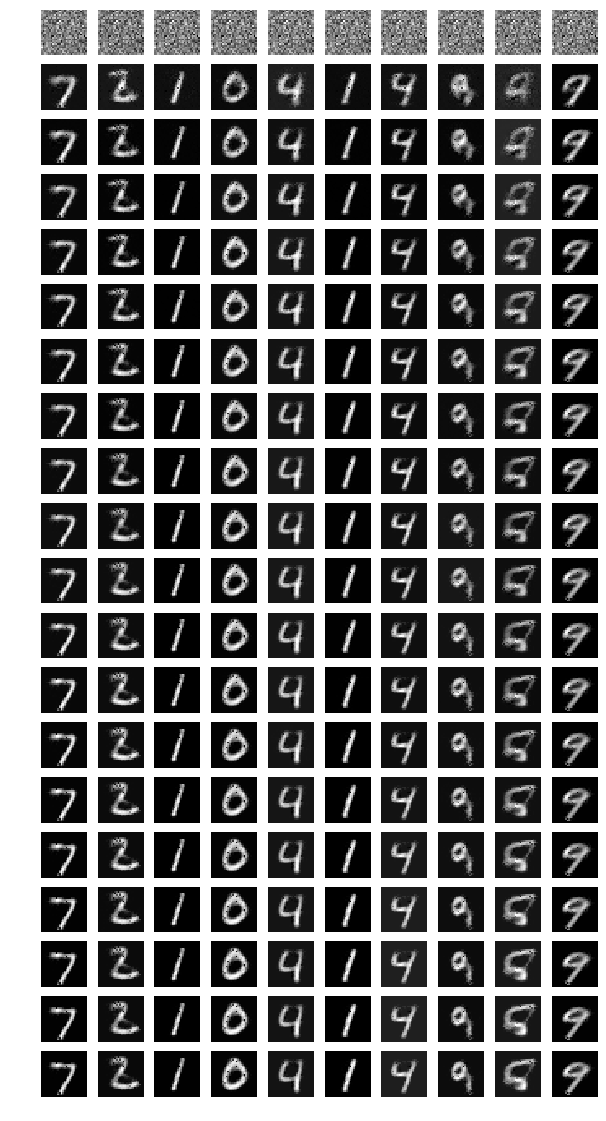

In [58]:
l = x_train.shape[0]
batch_size = 100
total_epoch = 20
losses = np.zeros(total_epoch)
num_plots = 10
diff = 10000
tolerance = 0.1 #measures convergence of loss over epochs
fig, ax = plt.subplots(nrows=total_epoch, ncols=num_plots, figsize=(num_plots, total_epoch))
samples = []
sess = tf.Session()
sess.run(tf.global_variables_initializer())

#print ("Variables before training")
#for var in tf.global_variables():
#    print (var.name, sess.run(var))

with tf.train.MonitoredSession() as sess:
    while diff > tolerance:
        for epoch in range(total_epoch):
            #This excutes the calculation of loss, and reconstruction/decoding of test dataset
            test_loss,test_reconst= sess.run([loss, data_reconst], {data: x_test,constant_sigma_bool:True}) 

            print('Epoch:', epoch, 'loss=', test_loss)
            
            #Calculates the difference in the current loss with the previous loss. 
            #If diff < tolerance, the loss has converged enough, 
            #so the training would stop before completing 'total_epochs' epochs
            if epoch>0:
                diff = test_loss - losses[epoch-1]
            
            losses[epoch] = test_loss

            #plots the first 10 test images reconstructed from its original, showing improvement in the quality of reconstruction 
            ax[epoch, 0].set_ylabel('Epoch {}'.format(epoch))
            plot_reconstructed_images(ax[epoch, 0:], test_reconst[0:10])

            #the model is then trained on training datasets, in batch size of 100
            for k in range(0, 60000, batch_size):
                batch_num = k/(batch_size)
                batch_train = x_train[k:k + batch_size]
                sess.run(optimize, {data: batch_train}) #This trains the optimizer

            #In each epoch, sample 10*z_size random floats from the standard Normal Distribution.     
            sample_z = np.random.randn(num_plots, z_size)  

            #Feed 10 randomly generated z-arrays into the decoder to reconstruct new images of digits 
            gen_samples = sess.run(data_reconst, feed_dict={z:sample_z,constant_sigma_bool:True})
            samples.append(gen_samples)

## Plotting 100 random examples

In [20]:
'''
reshape_to_3D reshapes the reconstructed images (in 2D array) into 3D for the purpose of visualisation
Input x_2D: 2D array, the flattened version of reconstruction from MNIST dataset
Output x_3D: 3D array
'''
def reshape_to_3D(x_2D):
    x_3D = x_2D.reshape(x_2D.shape[0],int(x_2D.shape[1]**(1/2)),int(x_2D.shape[1]**(1/2)))
    return x_3D

'''
Plot reconstructed images, in 10 x 10 grid
'''
def plot_100_xhat(x_hat):
    x_hat = reshape_to_3D(x_hat) * 255.0
    fig = plt.figure(figsize=(10,8))
        
    for i in range(100):
        ax = fig.add_subplot(10, 10, i+1)
        ax.imshow(x_hat[i], cmap='gray')
    
    fig.suptitle('Autoencoded Test Sample')
    plt.show()


'''
Plot original test images, in 10 x 10 grid
''' 
def plot_100_xtest(x_test):
    fig = plt.figure(figsize=(10,8))
        
    for i in range(100):
        ax = fig.add_subplot(10, 10, i+1)
        ax.imshow(x_test[i]*255.0, cmap='gray')
    
    fig.suptitle('Original Test Sample')
    plt.show()

'''
Plot test error per epoch
'''
def plot_test_losses(losses, const_sigma=True):
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.show()

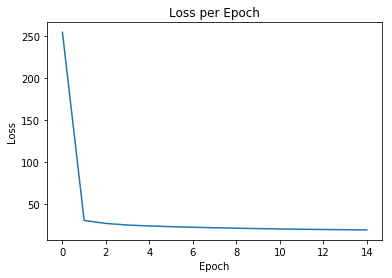

In [203]:
plot_test_losses(losses, const_sigma=True)

## Compare 100 reconstructed images with original

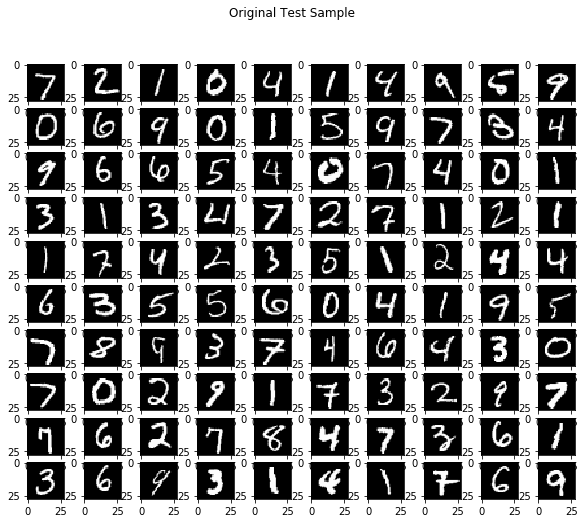

In [149]:
#Original dataset
plot_100_xtest(x_test)

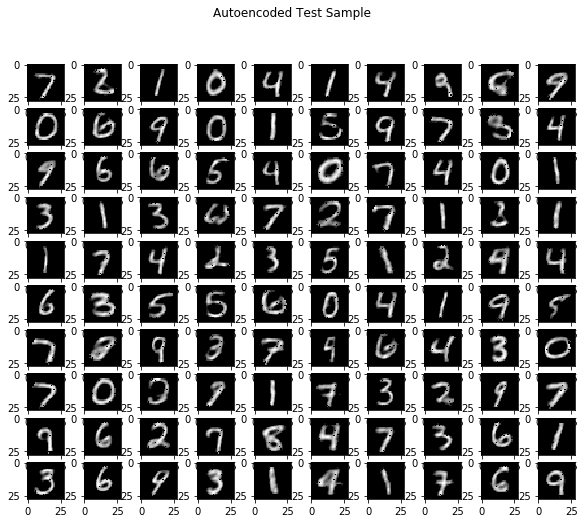

In [150]:
#Reconstructeed dataset
plot_100_xhat(test_reconst[0:100])

## VAE as Generative model 

After training, VAE will be able to directly generate images from the latent distribution p(z) ~ N(0,1).
To visualise the improvement of generative power of the model over epochs, we plot 10 generated images based on 10 randomly sampled latent in each epoch. 

In [56]:
def generate_digits(samples):
    
    width = 1.0
    plt.figure(figsize=(width*num_plots, len(samples) * width))
    
    for epoch, images in enumerate(samples):
        for digit, image in enumerate(images):
            plt.subplot(len(samples),num_plots,epoch * num_plots + digit + 1)
            plt.imshow(image.reshape((28, 28))*255.0,cmap='gray')
            plt.gca().xaxis.set_visible(False)
            
            if digit == 0:
                plt.gca().yaxis.set_ticks([])
                plt.ylabel('epoch {}'.format(epoch + 1),
                           verticalalignment='center',
                           horizontalalignment='right',
                           rotation=0,
                           fontsize=14)
            else:
                plt.gca().yaxis.set_visible(False)

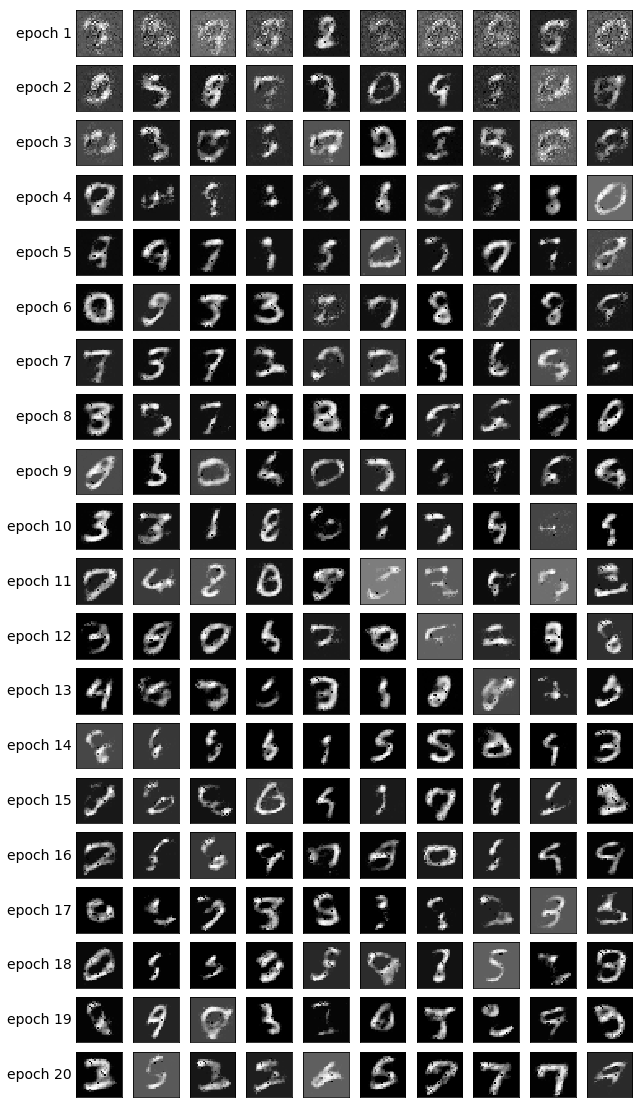

In [51]:
generate_digits(samples)

# Training with sigma_x and sigma_z as a layers in Neural Network

Set constant_sigma_bool to be False, so $\sigma_z$ and $\sigma_x$ are computed as layers in the Neural Network

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch: 0 loss= 296.15594
Epoch: 1 loss= 33.40686
Epoch: 2 loss= 28.558952
Epoch: 3 loss= 26.265455
Epoch: 4 loss= 24.924717
Epoch: 5 loss= 23.53459
Epoch: 6 loss= 22.67144
Epoch: 7 loss= 22.035164
Epoch: 8 loss= 21.482954
Epoch: 9 loss= 21.006641
Epoch: 10 loss= 20.59918
Epoch: 11 loss= 20.217367
Epoch: 12 loss= 19.899385
Epoch: 13 loss= 19.633722
Epoch: 14 loss= 19.346859
Epoch: 15 loss= 19.101927
Epoch: 16 loss= 18.824995
Epoch: 17 loss= 18.670856
Epoch: 18 loss= 18.503094
Epoch: 19 loss= 18.330772


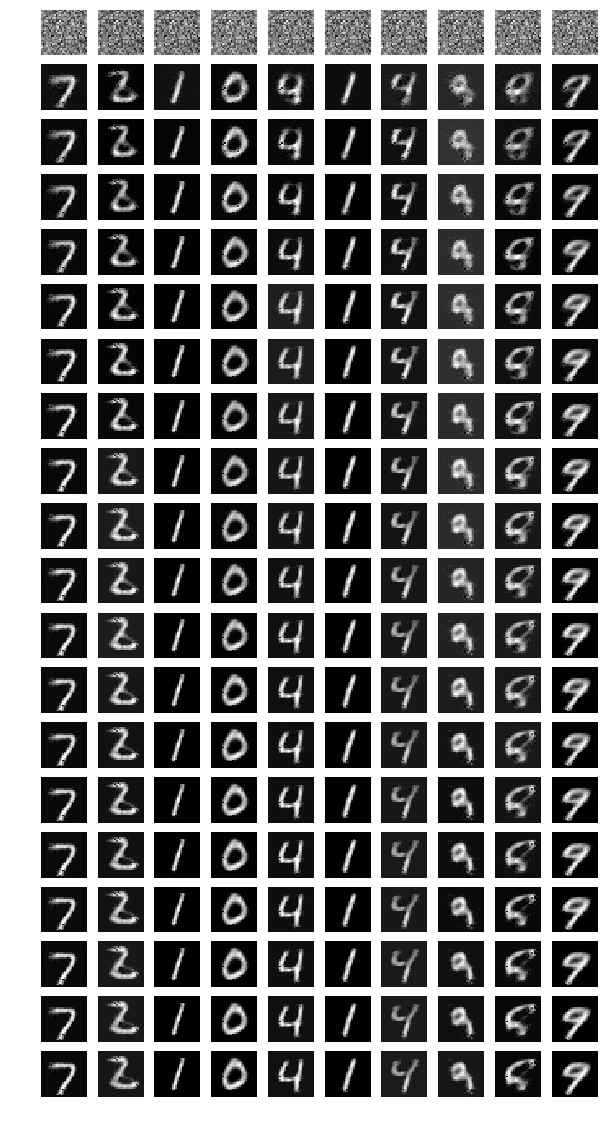

In [60]:
l = x_train.shape[0]
batch_size = 100
total_epoch = 20
losses = np.zeros(total_epoch)
num_plots = 10
diff = 10000
tolerance = 0.1
fig, ax = plt.subplots(nrows=total_epoch, ncols=num_plots, figsize=(num_plots, total_epoch))
samples = []
sess = tf.Session()
sess.run(tf.global_variables_initializer())

with tf.train.MonitoredSession() as sess:
    while diff > tolerance:
        for epoch in range(total_epoch):
            test_loss,test_reconst= sess.run([loss, data_reconst], {data: x_test,constant_sigma_bool:False}) 

            print('Epoch:', epoch, 'loss=', test_loss)


            if epoch>0:
                diff = test_loss - losses[epoch-1]

            losses[epoch] = test_loss

            ax[epoch, 0].set_ylabel('Epoch {}'.format(epoch))
            plot_reconstructed_images(ax[epoch, 0:], test_reconst[0:10])

            for k in range(0, 60000, batch_size):
                batch_num = k/(batch_size)
                batch_train = x_train[k:k + batch_size]
                sess.run(optimize, {data: batch_train}) #This trains the optimizer

            sample_z = np.random.randn(num_plots, z_size)  

            gen_samples = sess.run(data_reconst, feed_dict={z:sample_z,constant_sigma_bool:False})
            samples.append(gen_samples)

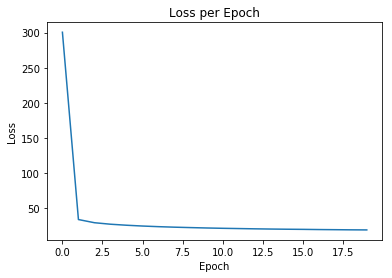

In [53]:
plot_test_losses(losses, const_sigma=False)

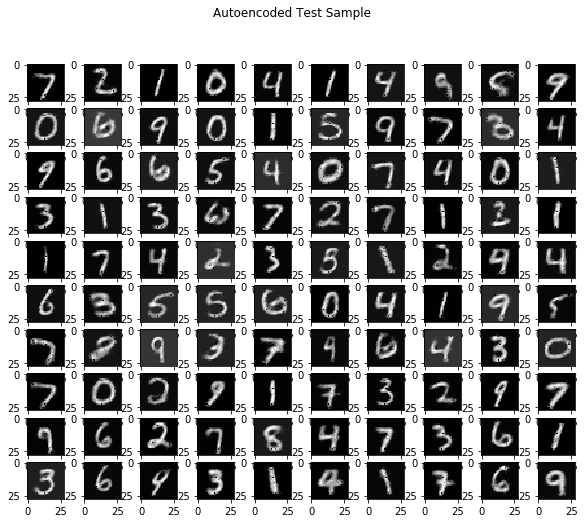

In [54]:
plot_100_xhat(test_reconst[0:100])

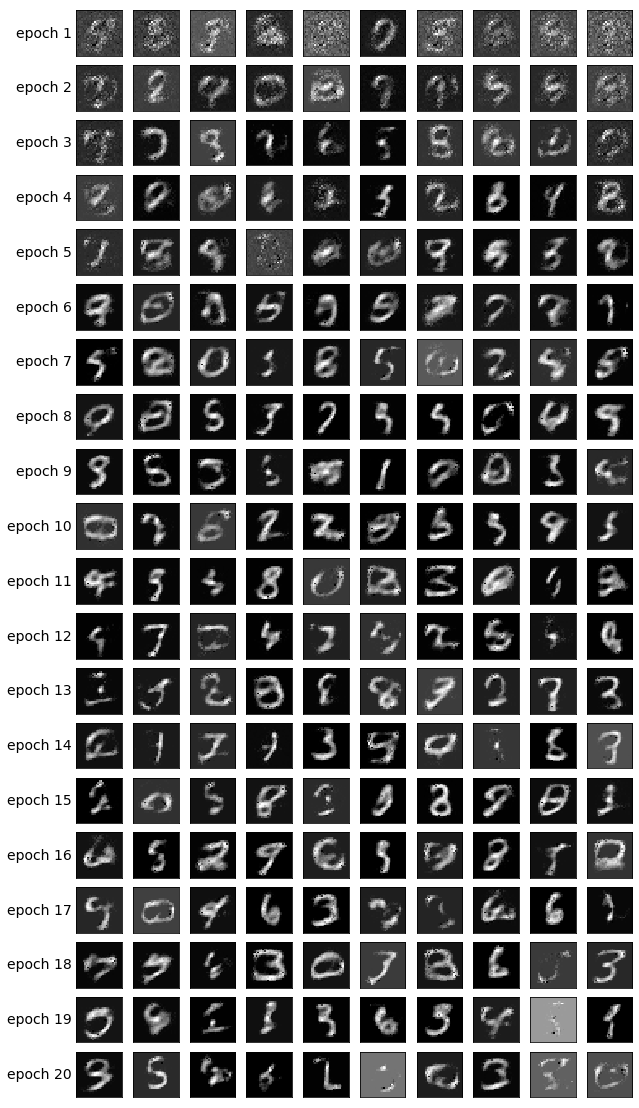

In [61]:
generate_digits(samples)